In [38]:
import pandas as pd
import numpy as np
from itertools import chain
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import pickle


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2


from sklearn.metrics import mean_squared_error
from math import sqrt

In [39]:
movies = pd.read_csv("dataset/movies.csv")
ratings = pd.read_csv("dataset/ratings.csv")

# 1. Data exploration
* !! If not interested in details, can just jump to [1.3. Summary from data exploration]

## 1.1 Explore movies dataset

In [40]:
# check the top three lines in movies

movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [41]:
# check if movieId is unique

unique_movieId = "" if set(movies.groupby("movieId").count()["title"].tolist()) == {1} else "not "
print(f"Each movie has {unique_movieId}unique movieId")

Each movie has unique movieId


In [42]:
# check if each title has the unique movieId

title_counts = movies['title'].value_counts()
shared_titles = title_counts[title_counts > 1].index.tolist()

print("The following movie titles were assigned movieId multiple times:")
movies[movies['title'].isin(shared_titles)].sort_values(by=['title'])


The following movie titles were assigned movieId multiple times:


,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [43]:
# if conflicted movies used in ratings dataset?

used = set(ratings["movieId"]) & set([6003, 26958, 32600, 168358,64997]) != set()
if_used = "used" if used else "not used"
print(f"For movie names that had overlap, they were {if_used} in ratings dataset")

For movie names that had overlap, they were used in ratings dataset


In [44]:
# after close observations:
# movies share the same title but different movieId should represent the same movies
# so I decide to 
# 1) inside movies dataset, delete: movieId in [6003, 26958, 32600, 168358,64997]
# 2) inside rating dataset, replace the deleted movieId with the correct one 

delete_movieId = {
    6003: 144606,
    26958: 838,
    32600: 147002,
    168358: 2851,
    64997: 34048,
}
movies = movies[~movies['movieId'].isin(delete_movieId.keys())].reset_index(drop=True)

# after delete duplicates, double confirm if succeed:
title_counts = movies['title'].value_counts()
is_complete = "successfully" if title_counts[title_counts > 1].index.tolist() == [] else "not successfully"
print(f"For movie names that had overlap, they were deleted {is_complete}")

# replace delete_movieId with the right one
for duplicated_id, correct_id in delete_movieId.items():
    ratings.loc[ratings['movieId'] == duplicated_id, 'movieId'] = correct_id

For movie names that had overlap, they were deleted successfully


In [45]:
# explore genres types
movies.explode('genres').groupby('genres').size()

genres
(no genres listed)                     34
Action                                 60
Action|Adventure                       32
Action|Adventure|Animation             18
Action|Adventure|Animation|Children     6
                                       ..
Sci-Fi|Thriller                        22
Sci-Fi|Thriller|IMAX                    1
Thriller                               84
War                                     4
Western                                23
Length: 951, dtype: int64

In [46]:
# The following movies have genres: (no genres listed)
movies[movies['genres'] == "(no genres listed)"]

,movieId,title,genres
8513,114335,La cravate (1957),(no genres listed)
8680,122888,Ben-hur (2016),(no genres listed)
8683,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
8778,129250,Superfast! (2015),(no genres listed)
8832,132084,Let It Be Me (1995),(no genres listed)
8898,134861,Trevor Noah: African American (2013),(no genres listed)
9029,141131,Guardians (2016),(no genres listed)
9049,141866,Green Room (2015),(no genres listed)
9066,142456,The Brand New Testament (2015),(no genres listed)
9087,143410,Hyena Road,(no genres listed)


In [47]:
# use chatgpt help assign genres for movies with unlabeled genres
movie_id_to_genre = {
    114335: "Drama",  # La cravate (1957)
    122888: "Action|Adventure|Drama",  # Ben-hur (2016)
    122896: "Action|Adventure|Fantasy",  # Pirates of the Caribbean: Dead Men Tell No Tales
    129250: "Comedy",  # Superfast! (2015)
    132084: "Romance|Musical",  # Let It Be Me (1995)
    134861: "Comedy",  # Trevor Noah: African American (2013)
    141131: "Action|Sci-Fi",  # Guardians (2016)
    141866: "Horror|Thriller",  # Green Room (2015)
    142456: "Comedy|Fantasy",  # The Brand New Testament (2015)
    143410: "War|Drama",  # Hyena Road
    147250: "Mystery|Crime|Drama",  # The Adventures of Sherlock Holmes and Doctor Watson
    149330: "Animation|Children|Fantasy",  # A Cosmic Christmas (1977)
    152037: "Musical",  # Grease Live (2016)
    155589: "Drama",  # Noin 7 veljestä (1968)
    156605: "Drama|Comedy",  # Paterson
    159161: "Comedy",  # Ali Wong: Baby Cobra (2016)
    159779: "Comedy|Fantasy|Romance",  # A Midsummer Night's Dream (2016)
    161008: "Drama|Romance",  # The Forbidden Dance (1990)
    165489: "Animation|Drama",  # Ethel & Ernest (2016)
    166024: "Drama|Music",  # Whiplash (2013)
    167570: "Drama|Sci-Fi|Mystery",  # The OA
    169034: "Music|Documentary",  # Lemonade (2016)
    171495: "Documentary|Sci-Fi",  # Cosmos
    171631: "Comedy",  # Maria Bamford: Old Baby
    171749: "Crime|Drama|Fantasy",  # Death Note: Desu nôto (2006–2007)
    171891: "Documentary",  # Generation Iron 2
    172497: "Action|Sci-Fi",  # T2 3-D: Battle Across Time (1996)
    172591: "Crime|Drama",  # The Godfather Trilogy: 1972-1990 (1992)
    173535: "Mystery|Crime|Drama",  # The Adventures of Sherlock Holmes and Doctor Watson (duplicate entry, for demonstration)
    174403: "Documentary",  # The Putin Interviews (2017)
    176601: "Sci-Fi|Drama|Thriller",  # Black Mirror
    181413: "Documentary|Comedy",  # Too Funny to Fail: The Life and Death of The Dana Carvey Show
    181719: "Drama|Romance",  # Serving in Silence: The Margarethe Cammermeyer Story
    182727: "Musical",  # A Christmas Story Live! (2017)
}

# Update the movies with assigned genres
for movie_id, genres in movie_id_to_genre.items():
    movies.loc[movies['movieId'] == movie_id, 'genres'] = genres

In [48]:
# check if all (no genres listed) have beed assigned with the right genres

movies[movies['genres'] == "(no genres listed)"]

,movieId,title,genres


In [49]:
# Extract year from the title and remove it from the title string
movies["year"] = movies['title'].str.extract(r'\((\d{4})\)')
movies['title'] = movies['title'].str.replace(r' \(\d{4}\)', '', regex=True)

# Split the genres string into a list of genres
movies['genres'] = movies['genres'].str.split('|')

In [50]:
# movies that have missing values: here is year
movies[movies[movies.columns].isnull().any(axis=1)]

,movieId,title,genres,year
6056,40697,Babylon 5,[Sci-Fi],NaN
9027,140956,Ready Player One,"[Action, Sci-Fi, Thriller]",NaN
9087,143410,Hyena Road,"[War, Drama]",NaN
9134,147250,The Adventures of Sherlock Holmes and Doctor W...,"[Mystery, Crime, Drama]",NaN
9175,149334,Nocturnal Animals,"[Drama, Thriller]",NaN
9255,156605,Paterson,"[Drama, Comedy]",NaN
9363,162414,Moonlight,[Drama],NaN
9444,167570,The OA,"[Drama, Sci-Fi, Mystery]",NaN
9509,171495,Cosmos,"[Documentary, Sci-Fi]",NaN
9510,171631,Maria Bamford: Old Baby,[Comedy],NaN


In [51]:
# assign year movies 
# Mapping of movieId to year
movie_id_to_year = {
    40697: 1994,  # Assuming the start year for the Babylon 5 series
    140956: 2018,  # Ready Player One
    143410: 2015,  # Hyena Road
    147250: 1980,  # The Adventures of Sherlock Holmes and Doctor Watson
    149334: 2016,  # Nocturnal Animals
    156605: 2016,  # Paterson
    162414: 2016,  # Moonlight
    167570: 2016,  # The OA, considering it as a series start year might be 2016
    171495: 2014,  # Cosmos, assuming this might refer to 'Cosmos: A Spacetime Odyssey' which started in 2014
    171631: 2017,  # Maria Bamford: Old Baby
    171749: 2006,  # Death Note: Desu nôto (2006–2007)
    171891: 2017,  # Generation Iron 2
    176601: 2011,  # Black Mirror, started in 2011
}

# Assuming 'df' is your DataFrame
for movie_id, year in movie_id_to_year.items():
    movies.loc[movies['movieId'] == movie_id, 'year'] = year
movies['year'] = movies['year'].astype(int)

In [52]:
# check if there is anymore missing values:
movies[movies[movies.columns].isnull().any(axis=1)]

,movieId,title,genres,year


## 1.2 Explore ratings dataset

In [53]:
# check the top three lines in movies

ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [54]:
# check if missing values
ratings[ratings[ratings.columns].isnull().any(axis=1)]

# no missing values

,userId,movieId,rating,timestamp


In [55]:
# check if all movieId shows up in movies

for i in set(ratings["movieId"].tolist()):
    if i not in set(movies['movieId'].tolist()):
        print(i)
        
# all movideId in ratings are valid bc shows up in movies

## 1.3 Summary from data exploration

### 1) What did I do in previous steps?

### 2) Preview of final datasets

In [56]:
movies.tail(3)

,movieId,title,genres,year
9734,193585,Flint,[Drama],2017
9735,193587,Bungo Stray Dogs: Dead Apple,"[Action, Animation]",2018
9736,193609,Andrew Dice Clay: Dice Rules,[Comedy],1991


In [57]:
ratings.tail(3)

,userId,movieId,rating,timestamp
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


### 3) Summary statistics

In [58]:
# 0) Each Column Type
column_types = movies.dtypes

# 1) Number of Rows, Columns
num_rows, num_columns = movies.shape

# 2) Unique Genres List and Count
all_genres = [genre for sublist in movies.genres for genre in sublist]
unique_genres = set(all_genres)
num_unique_genres = len(unique_genres)

# 3) Year Range, Count for Each Year
year_range = (movies['year'].min(), movies['year'].max())
year_counts = movies['year'].value_counts().sort_index()

# Displaying the results
results = {
    "Column Types": column_types,
    "Dataset Size": f"{num_rows} movies, {num_columns} attributes",
    "Genres": f"There are {num_unique_genres} unique genres",
    "Unique Genres": unique_genres,
    "Year Range": f"{year_range[0]} to {year_range[1]}",
    "Year Counts": year_counts
}


for i, (key, value) in enumerate(results.items()):
    if isinstance(value, pd.Series) or isinstance(value, set) or isinstance(value, Counter):
        print(f"{i}) {key}:")
        print(value)
        print("\n")
    else:
        print(f"{i}) {key}: {value}\n")


0) Column Types:
movieId     int64
title      object
genres     object
year        int64
dtype: object


1) Dataset Size: 9737 movies, 4 attributes

2) Genres: There are 20 unique genres

3) Unique Genres:
{'War', 'Sci-Fi', 'Western', 'Drama', 'Music', 'Fantasy', 'Musical', 'Mystery', 'Adventure', 'Action', 'Children', 'Crime', 'Documentary', 'IMAX', 'Comedy', 'Thriller', 'Animation', 'Romance', 'Horror', 'Film-Noir'}


4) Year Range: 1902 to 2018

5) Year Counts:
1902      1
1903      1
1908      1
1915      1
1916      4
       ... 
2014    279
2015    275
2016    222
2017    149
2018     42
Name: year, Length: 106, dtype: int64




In [59]:
# 0) Each Column Datatype
column_datatypes = ratings.dtypes

# 1) Number of Rows, Number of Attributes
num_rows, num_columns = ratings.shape

# 2) Number of Unique User IDs, Unique Movie IDs
num_unique_users = ratings['userId'].nunique()
num_unique_movies = ratings['movieId'].nunique()

# 3) Rating Count Frequency
rating_counts = ratings['rating'].value_counts()

# 4) Rating Range
rating_range = (ratings['rating'].min(), ratings['rating'].max())

# Displaying the results
results = {
        "Column Datatypes": column_datatypes,
        "Dataset Size": f"{num_rows} rows, {num_columns} attributes",
        "Unique Users": f"{num_unique_users} unique users",
        "Unique Movies": f"{num_unique_movies} unique users",
        "Rating Frequencies": rating_counts,
        "Rating Range": f"Min: {rating_range[0]}, Max: {rating_range[1]}"
}


for i, (key, value) in enumerate(results.items()):
    if isinstance(value, pd.Series) or isinstance(value, set) or isinstance(value, Counter):
        print(f"{i}) {key}:")
        print(value)
        print("\n")
    else:
        print(f"{i}) {key}: {value}\n")


0) Column Datatypes:
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


1) Dataset Size: 100836 rows, 4 attributes

2) Unique Users: 610 unique users

3) Unique Movies: 9719 unique users

4) Rating Frequencies:
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64


5) Rating Range: Min: 0.5, Max: 5.0



# 2. Feature Engineering

## 2.1 Split into train and test

In [60]:
def split_data_by_user(data, test_size=0.5, random_state=42):
    train_data = pd.DataFrame(columns=data.columns)
    test_data = pd.DataFrame(columns=data.columns)
    
    unique_users = data['userId'].unique()
    
    for user in unique_users:
        user_data = data[data['userId'] == user]
        train_user, test_user = train_test_split(user_data, test_size=test_size, random_state=random_state)
        train_data = pd.concat([train_data, train_user]).reset_index(drop=True)
        test_data = pd.concat([test_data, test_user]).reset_index(drop=True)
    
    return train_data, test_data

# Split the data
train, test = split_data_by_user(ratings)

# Merge dataframes: ratings + movies
train_data = pd.merge(train, movies, on='movieId', how='left')
test_data = pd.merge(test, movies, on='movieId', how='left')

## 2.2 Add extra features
user_average_rating, 
movie_rated_cnt, 
movie_rated_cnt

In [61]:
# Calculate user_average_rating
user_avg_rating = train_data.groupby('userId')['rating'].mean().reset_index()
user_avg_rating.columns = ['userId', 'user_average_rating']

# Calculate movie_rated_cnt
movie_rated_cnt = train_data.groupby('movieId')['userId'].count().reset_index()
movie_rated_cnt.columns = ['movieId', 'movie_rated_cnt']

# Calculate movie_average_rating
movie_avg_rating = train_data.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating.columns = ['movieId', 'movie_average_rating']

# Merge the new columns into the original train_data
train_data = pd.merge(train_data, user_avg_rating, on='userId', how='left')
train_data = pd.merge(train_data, movie_rated_cnt, on='movieId', how='left')
train_data = pd.merge(train_data, movie_avg_rating, on='movieId', how='left')
# Fill NaN values with appropriate defaults (if needed)
train_data['user_average_rating'].fillna(0, inplace=True)
train_data['movie_rated_cnt'].fillna(0, inplace=True)
train_data['movie_average_rating'].fillna(0, inplace=True)


# Merge the new columns into the original test_data
test_data = pd.merge(test_data, user_avg_rating, on='userId', how='left')
test_data = pd.merge(test_data, movie_rated_cnt, on='movieId', how='left')
test_data = pd.merge(test_data, movie_avg_rating, on='movieId', how='left')
# Fill NaN values with appropriate defaults (if needed)
test_data['user_average_rating'].fillna(0, inplace=True)
test_data['movie_rated_cnt'].fillna(0, inplace=True)
test_data['movie_average_rating'].fillna(0, inplace=True)


# Get mean and median for movie_rated_cnt
movie_rated_cnt_mean = np.mean(train_data["movie_rated_cnt"].tolist())
movie_rated_cnt_median = np.median(train_data["movie_rated_cnt"].tolist())
print(f"Each movie number of ratings, mean: {round(movie_rated_cnt_mean)}, median is {movie_rated_cnt_median}")

# if movie_rated_cnt <= 4: it means not too many (4 is customized, can be changed)
train_data = train_data[train_data["movie_rated_cnt"] >= 4].reset_index(drop=True)

Each movie number of ratings, mean: 29, median is 19.0


## 2.3 Encode features

In [62]:
# 1) genres: multiple classes into a binary matrix
genres_encoder = MultiLabelBinarizer()
genres_encoder.fit(movies['genres'])
train_genres_encoded = genres_encoder.transform(train_data['genres'])
test_genres_encoded = genres_encoder.transform(test_data['genres'])

# 2) year: normalization
year_scaler = MinMaxScaler()
year_scaler.fit(np.array(movies["year"]).reshape(-1, 1))
train_years_normalized = year_scaler.transform(np.array(train_data["year"]).reshape(-1, 1))
test_years_normalized = year_scaler.transform(np.array(test_data["year"]).reshape(-1, 1))

# 3) movieId: onehot encoding
movieId_encoder = OneHotEncoder(sparse=False)
movieId_encoder.fit(movies[['movieId']])
train_movieId_encoded = movieId_encoder.transform(train_data[['movieId']])
test_movieId_encoded = movieId_encoder.transform(test_data[['movieId']])

# 4) title: tfidf to convert titles
title_vectorizer = TfidfVectorizer(max_features=1000)
title_vectorizer.fit(movies["title"])
train_title_encoded = title_vectorizer.transform(train_data["title"]).toarray()
test_title_encoded = title_vectorizer.transform(test_data["title"]).toarray()

# 5) userId
userId_encoder = OneHotEncoder(sparse=False)
userId_encoder.fit(ratings[['userId']].drop_duplicates().reset_index(drop=True))
train_userId_encoded = userId_encoder.transform(train_data[['userId']])
test_userId_encoded = userId_encoder.transform(test_data[['userId']])

# 6) user_average_rating
user_average_rating_scaler = MinMaxScaler()
train_user_average_rating_normalized = user_average_rating_scaler.fit_transform(np.array(train_data["user_average_rating"]).reshape(-1, 1))
test_user_average_rating_normalized = user_average_rating_scaler.transform(np.array(test_data["user_average_rating"]).reshape(-1, 1))

# 7) movie_rated_cnt
movie_rated_cnt_scaler = MinMaxScaler()
train_movie_rated_cnt_normalized = movie_rated_cnt_scaler.fit_transform(np.array(train_data["movie_rated_cnt"]).reshape(-1, 1))
test_movie_rated_cnt_normalized = movie_rated_cnt_scaler.transform(np.array(test_data["movie_rated_cnt"]).reshape(-1, 1))

# 8) movie_average_rating
movie_average_rating_scaler = MinMaxScaler()
train_movie_average_rating_normalized = movie_average_rating_scaler.fit_transform(np.array(train_data["movie_average_rating"]).reshape(-1, 1))
test_movie_average_rating_normalized = movie_average_rating_scaler.transform(np.array(test_data["movie_average_rating"]).reshape(-1, 1))

/Users/ronghuang/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ronghuang/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


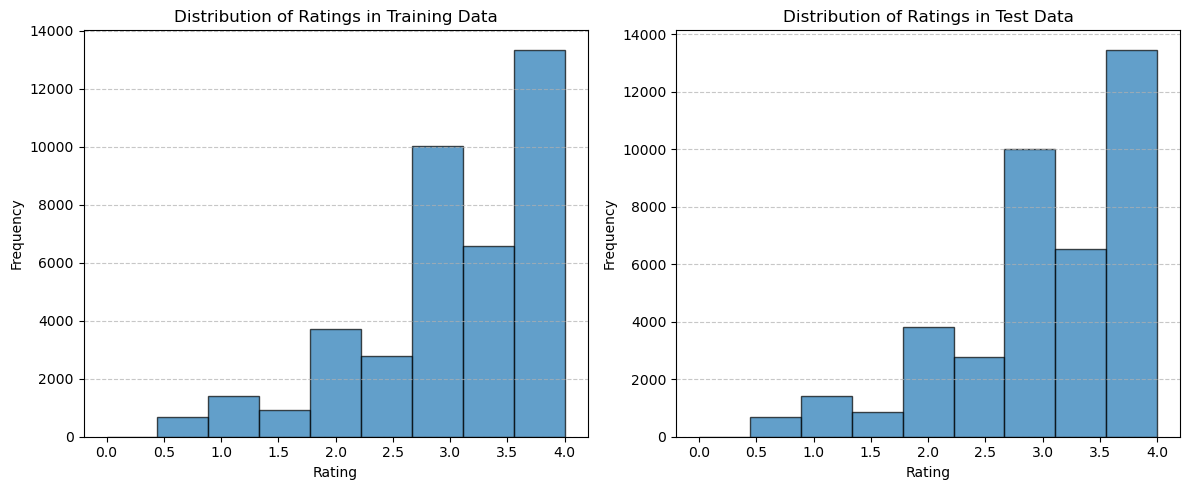

In [63]:
# ratings

import matplotlib.pyplot as plt

# Assuming 'train' is your training dataset and 'rating' is the column you want to plot
train_rating = train['rating']

# Assuming 'test' is your test dataset and 'rating' is the column you want to plot
test_rating = test['rating']

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram for training data
axs[0].hist(train_rating, bins=9, range=(0, 4), edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of Ratings in Training Data')
axs[0].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])  # Set x-axis ticks to match your rating values
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the histogram for test data
axs[1].hist(test_rating, bins=9, range=(0, 4), edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Ratings in Test Data')
axs[1].set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])  # Set x-axis ticks to match your rating values
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## 2.4 Prepare X, y for model

In [64]:
train_data.head(3)

,userId,movieId,rating,timestamp,title,genres,year,user_average_rating,movie_rated_cnt,movie_average_rating
0,1,3439,4.0,964981799,Teenage Mutant Ninja Turtles II: The Secret of...,"[Action, Children, Fantasy]",1991,4.318966,6,2.833333
1,1,2858,5.0,964980868,American Beauty,"[Drama, Romance]",1999,4.318966,108,4.037037
2,1,592,4.0,964982271,Batman,"[Action, Crime, Thriller]",1989,4.318966,107,3.467290


In [65]:
# Prepare inputs and outputs for the model

y_train = train_data['rating'].values
y_test = test_data['rating'].values

X_train = np.concatenate([train_movieId_encoded,
                         train_movie_rated_cnt_normalized, 
                         train_movie_average_rating_normalized, 
                         train_title_encoded, 
                         train_years_normalized, 
                         train_genres_encoded, 
                         train_userId_encoded,
                         train_user_average_rating_normalized], axis=1)

X_test = np.concatenate([test_movieId_encoded,
                         test_movie_rated_cnt_normalized, 
                         test_movie_average_rating_normalized, 
                         test_title_encoded, 
                         test_years_normalized, 
                         test_genres_encoded, 
                         test_userId_encoded,
                         test_user_average_rating_normalized], axis=1)

In [66]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43169, 11371) (43169,)
(50566, 11371) (50566,)


In [67]:
train_data.to_csv('dataset/train_data.csv', index=False)
test_data.to_csv('dataset/test_data.csv', index=False)

# 3. Training

## 3.1 Building & train the Neural Network

Epoch 1/15
270/270 [==============================] - 2s 6ms/step - loss: 6.8255 - val_loss: 1.1123
Epoch 2/15
270/270 [==============================] - 1s 5ms/step - loss: 1.8628 - val_loss: 0.9547
Epoch 3/15
270/270 [==============================] - 1s 5ms/step - loss: 1.2650 - val_loss: 0.8666
Epoch 4/15
270/270 [==============================] - 1s 5ms/step - loss: 1.0146 - val_loss: 0.8486
Epoch 5/15
270/270 [==============================] - 1s 5ms/step - loss: 0.8789 - val_loss: 0.8367
Epoch 6/15
270/270 [==============================] - 1s 5ms/step - loss: 0.7973 - val_loss: 0.8302
Epoch 7/15
270/270 [==============================] - 1s 5ms/step - loss: 0.7427 - val_loss: 0.8374
Epoch 8/15
270/270 [==============================] - 1s 5ms/step - loss: 0.7053 - val_loss: 0.8376
Epoch 9/15
270/270 [==============================] - 1s 5ms/step - loss: 0.6894 - val_loss: 0.8386
Epoch 10/15
270/270 [==============================] - 1s 5ms/step - loss: 0.6729 - val_loss: 0.8400

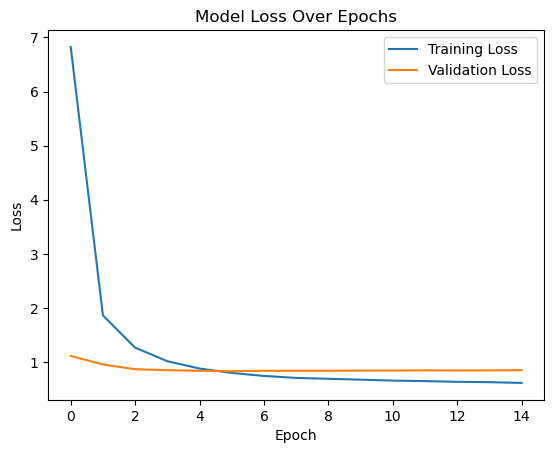

In [68]:
model = Sequential([
        
    Dense(64, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    BatchNormalization(),
    
    Dense(1)  # Output layer: Predicting a single rating
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=128,
    verbose=1,
)

# Plotting training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/train_validation_loss.png')

plt.show()

# save mode
model.save("saved_model/model.keras")

## 3.2 Evaluation on Test Dataset

In [70]:
# Calculate RMSE
predicted_ratings =  model.predict(X_test).flatten()
rmse = sqrt(mean_squared_error(y_test, predicted_ratings))
print(f"Root Mean Squared Error: {rmse}")

1581/1581 [==============================] - 1s 555us/step
Root Mean Squared Error: 0.9231159436752163


# 4. Recommendations

## 4.1 Prepare dictionary for recommendations

In [84]:
# feature preparation

# 1) genres: multiple classes into a binary matrix
movies_genres_encoded = genres_encoder.transform(movies['genres'])

# 2) year: normalization
movies_years_normalized = year_scaler.transform(np.array(movies["year"]).reshape(-1, 1))

# 3) movieId: onehot encoding
movies_movieId_encoded = movieId_encoder.transform(movies[['movieId']])

# 4) title: tfidf to convert titles
movies_title_encoded = title_vectorizer.transform(movies["title"]).toarray()

# 5) userId
unique_users = ratings[['userId']].drop_duplicates().reset_index(drop=True)
unique_userId_encoded = userId_encoder.transform(unique_users)

# 6) user_average_rating
user_average_rating_df = pd.DataFrame({
    'userId': train_data['userId'],
    'user_average_rating': train_user_average_rating_normalized.flatten(),
    })
userId_average_rating_dict = user_average_rating_df.drop_duplicates().set_index('userId')['user_average_rating'].to_dict()

# 7) movie_rated_cnt + movie_average_rating
movies_stats = pd.merge(movies, train_data[["movieId", "movie_rated_cnt", "movie_average_rating"]].drop_duplicates(), on="movieId", how="left").fillna(0)[["movieId", "movie_rated_cnt", "movie_average_rating"]]
movie_rated_cnt_dict = movies_stats.set_index("movieId")["movie_rated_cnt"].to_dict()
movie_average_rating_dict = movies_stats.set_index("movieId")["movie_average_rating"].to_dict()

In [88]:
# Other usesful dictionaries

# 1) movieId_to_name = {movideId: name} 
movieId_to_name = {}
for movieId, title in zip(movies["movieId"].tolist(),movies["title"].tolist()): 
    movieId_to_name[movieId] = title
    
    
# 2) [train dataset] ratings_by_user_train = {userId: [rated_movieId1, rated_movieId2,... ]}

ratings_by_user_train = {}
for _, row in train[train.columns[:-1]].iterrows():
    user_id, movie_id, rating = row[0], row[1], row[2]
    
    if user_id not in ratings_by_user_train:
        ratings_by_user_train[user_id] = []

    ratings_by_user_train[user_id].append(movie_id)

    
# 3) [test dataset] ratings_by_user_test = {userId: {movie_id: rating}} 
# order by ratings descring, movieId increasing
ratings_by_user_test = {}
for _, row in test[test.columns[:-1]].iterrows():
    user_id, movie_id, rating = row[0], row[1], row[2]
    
    if user_id not in ratings_by_user_test:
        ratings_by_user_test[user_id] = {}

    ratings_by_user_test[user_id][movie_id] = rating

    
# 4) [train dataset] {movieId: view_freq}
movie_view_frequency = {} 
view_frequency = train_data['movieId'].value_counts()
for movie_id, view_count in view_frequency.items():
    movie_view_frequency[movie_id] = view_count
# average/median view for each movie
mean_view_freq = np.mean(list(movie_view_frequency.values()))
median_view_freq = np.median(list(movie_view_frequency.values()))

print(f"mean: {round(mean_view_freq, 1)}, median_view_freq: {round(median_view_freq, 1)}")


# 5) [test dataset] userId top 5 higest rated movie: 
#     userId_top_5_movies = {userId: [top1_rated_movie, ..., top2_rated_movie]}

userId_top_5_movies = {}
popularity = []
for userId in ratings_by_user_test.keys():
    movies_list = list(ratings_by_user_test[userId].keys())
    ratings_list = list(ratings_by_user_test[userId].values())
    # rank by [-ratings, -popularities]
    for m in movies_list:
        if m not in movie_view_frequency:
            popularity.append(0)
        else:
            popularity.append(movie_view_frequency[m])    
    combined_data = list(zip(movies_list, ratings_list, popularity))
    sorted_data = sorted(combined_data, key=lambda x: (-x[1], -x[2]))
    sorted_movieId = [item[0] for item in sorted_data]
    
    userId_top_5_movies[userId] = sorted_movieId[:5]

mean: 15.0, median_view_freq: 9.0


In [89]:
to_save_dicts = True

if to_save_dicts:
    # Save dictionaries to files
    with open('saved_dicts/movieId_to_name.pkl', 'wb') as f:
        pickle.dump(movieId_to_name, f)

    with open('saved_dicts/ratings_by_user_train.pkl', 'wb') as f:
        pickle.dump(ratings_by_user_train, f)

    with open('saved_dicts/ratings_by_user_test.pkl', 'wb') as f:
        pickle.dump(ratings_by_user_test, f)

    with open('saved_dicts/movie_view_frequency.pkl', 'wb') as f:
        pickle.dump(movie_view_frequency, f)

    with open('saved_dicts/userId_top_5_movies.pkl', 'wb') as f:
        pickle.dump(userId_top_5_movies, f)

In [665]:
# with open('movieId_to_name.pkl', 'rb') as f:
#     movieId_to_name = pickle.load(f)

# with open('ratings_by_user_train.pkl', 'rb') as f:
#     ratings_by_user_train = pickle.load(f)

# with open('ratings_by_user_test.pkl', 'rb') as f:
#     ratings_by_user_test = pickle.load(f)

# with open('movie_view_frequency.pkl', 'rb') as f:
#     movie_view_frequency = pickle.load(f)

# with open('userId_top_5_movies.pkl', 'rb') as f:
#     userId_top_5_movies = pickle.load(f)

## 4.2 User embeddings and movie embeddings

In [90]:
# movie embeddings
# {movieId: movie information embedding}

movies_emb = {}
for i, movieId in enumerate(movies["movieId"].tolist()):
    movies_emb[movieId] = np.concatenate([movies_movieId_encoded[i].reshape(1, -1),
                                             np.array(movie_rated_cnt_dict[movieId]).reshape(1, -1),
                                             np.array(movie_average_rating_dict[movieId]).reshape(1, -1),
                                             movies_title_encoded[i].reshape(1, -1),
                                             movies_years_normalized[i].reshape(1, -1),
                                             movies_genres_encoded[i].reshape(1, -1),
                                            ], axis=1)

# user embeddings
# {userId: user information embedding}

userId_emb = {}
for i, userId in enumerate(unique_users["userId"].tolist()):
    userId_emb[userId] = np.concatenate([unique_userId_encoded[i].reshape(1, -1),
                                        np.array(userId_average_rating_dict[userId]).reshape(1, -1)], axis = 1)

In [91]:
if to_save_dicts:
    with open('saved_dicts/movies_emb.pkl', 'wb') as f:
        pickle.dump(movies_emb, f)

    with open('saved_dicts/userId_emb.pkl', 'wb') as f:
        pickle.dump(userId_emb, f)

In [668]:
# with open('movies_emb.pkl', 'rb') as f:
#     movies_emb = pickle.load(f)

# with open('userId_emb.pkl', 'rb') as f:
#     userId_emb = pickle.load(f)

## 4.2 Recommendation functon

In [92]:
def recommend(userId, k):
    
    print("************************** Start **************************")
    print(f"User {userId}: rated {len(ratings_by_user_train[userId])} in training dataset")

    # find all unrated movies for userId
    unseen_movies_emb = []
    unseen_movieId = []
    for movieId, emb in movies_emb.items():
        if movieId not in set(ratings_by_user_train[userId]):
            unseen_movies_emb.append(emb)
            unseen_movieId.append(movieId)
    unseen_movies_emb = np.concatenate(unseen_movies_emb, axis=0)

    # prepare X for this user: [moive_embd, userId_emb]
    user_emb_broadcasted = np.tile(userId_emb[userId], (unseen_movies_emb.shape[0], 1))

    # final X embedding for userId and all unseen movies
    X_emb = np.hstack((unseen_movies_emb, user_emb_broadcasted))

    # predict scores for unseen movies
    unseen_ratings = model.predict(X_emb).flatten()

    # popularity for unseen movies (rated numbers)
    popularity = []
    for i, movieId in enumerate(unseen_movieId):

        if movieId not in movie_view_frequency:
            popularity.append(0)
        else:
            popularity.append(movie_view_frequency[movieId]) 

    # sort the predicted movies scores [and popularity] from high to low 
    combined_data = list(zip(unseen_movieId, unseen_ratings, popularity))
    # seen at least twice in train, then it can be recommended
    combined_data = [item for item in combined_data if item[2] >= 4]

    sorted_data = sorted(combined_data, key=lambda x: (-x[1], -x[2]))
    sorted_unseen_movieId = [item[0] for item in sorted_data]
    sorted_unseen_ratings = [item[1] for item in sorted_data]
    
    print()
    print("1) If the top 5 recommendation is actually rated in test dataset, displayed below:")
    # print the top k highest
    # Define the bin edges
    bin_edges = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    top_k_recommendations = [] # [[movieIds], [predicted_ratings]]
    for movieId, predicted_score in zip(sorted_unseen_movieId[:k], sorted_unseen_ratings[:k]):
        predicted_score = bin_edges[np.digitize(predicted_score, bin_edges) - 1] 
        top_k_recommendations.append([movieId,predicted_score])

        # check how well are predictions
        if movieId in set(ratings_by_user_test[userId].keys()):
            print(f"movieId {movieId}: predicted as {predicted_score}, true: {ratings_by_user_test[userId][movieId]}")
        else:
            pass
        
    # check top5 highest rated movies for userId in test dataset
    print()
    print("2) top 5 rated movies in test dataset")
    
    X_top5_emb = []
    for movieId in userId_top_5_movies[userId]:
        X_top5_emb.append(movies_emb[movieId])

    X_top5_emb = np.concatenate(X_top5_emb, axis=0)
    user_emb_broadcasted = np.tile(userId_emb[userId], (X_top5_emb.shape[0], 1))
    X_top5_emb = np.hstack((X_top5_emb, user_emb_broadcasted))

    # predict scores for top5 movies
    X_top5_emb_predicted_ratings = model.predict(X_top5_emb).flatten()
    for i, movieId in enumerate(userId_top_5_movies[userId]):
        predicted_score = bin_edges[np.digitize(X_top5_emb_predicted_ratings[i], bin_edges) - 1] 
        print(f"{movieId}, predicted: {predicted_score}, true: {ratings_by_user_test[userId][movieId]}")
    
    
    print("************************** End **************************")
    print()
    print()
    return top_k_recommendations

In [93]:
k = 5

test_user = [1, 20, 111, 610]
for i in test_user:
    top_k_recommendations = recommend(i, k)

************************** Start **************************
User 1: rated 116 in training dataset
301/301 [==============================] - 0s 609us/step

1) If the top 5 recommendation is actually rated in test dataset, displayed below:
movieId 296: predicted as 5, true: 3.0
movieId 480: predicted as 5, true: 4.0
movieId 260: predicted as 5, true: 5.0

2) top 5 rated movies in test dataset
1/1 [==============================] - 0s 8ms/step
260, predicted: 5, true: 5.0
1196, predicted: 5, true: 5.0
527, predicted: 5, true: 5.0
1210, predicted: 5, true: 5.0
1270, predicted: 5, true: 5.0
************************** End **************************


************************** Start **************************
User 20: rated 121 in training dataset
301/301 [==============================] - 0s 594us/step

1) If the top 5 recommendation is actually rated in test dataset, displayed below:

2) top 5 rated movies in test dataset
1/1 [==============================] - 0s 8ms/step
594, predicted: 